In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
import shap
from matplotlib import colors
import random


2023-03-01 16:24:31.029238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 16:24:31.121873: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 16:24:31.462779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 16:24:31.462813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [21]:
with open('../data/prepared_data/SW_only_OTT_train_dict.pkl', 'rb') as f:
	train_dict = pickle.load(f)

with open('../data/prepared_data/SW_only_OTT_test_dict.pkl', 'rb') as d:
	test_dict = pickle.load(d)

with open(f'multi-station-dbdt-risk-assessment/models/scalers/combined_model_OTT_standardscaler.pkl', 'rb') as c:
	scaler = pickle.load(c)		
with open(f'multi-station-dbdt-risk-assessment/models/scalers/_SW_only_OTT_standardscaler.pkl', 'rb') as b:
	sw_scaler = pickle.load(b)

model = load_model('models/OTT/CNN_SW_only_split_50.h5')
results = pd.read_feather('outputs/OTT/SW_only_storm_4.feather')

In [3]:
print(train_dict['X'].shape)

(834961, 30, 10)


In [4]:
# reducing the amount of the training dataset used to find the shap values
x_train = train_dict['X']
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# attempting to use shap
explainer = shap.DeepExplainer(model, background)

print(x_train.shape)
print(explainer)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2023-03-01 16:24:41.053695: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-03-01 16:24:41.433005: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(834961, 30, 10, 1)


2023-03-01 16:24:41.751715: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
Xtest = test_dict['storm_4']['Y']
Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1))
print(test_dict['storm_4']['real_df']['crossing'][10])


0


In [6]:
results['predicted_split_50'][50]

0.78321666

In [7]:
shap_values = explainer.shap_values(Xtest, check_additivity=False)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [8]:
shap_values[1].shape
features = ["sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   		"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T"]

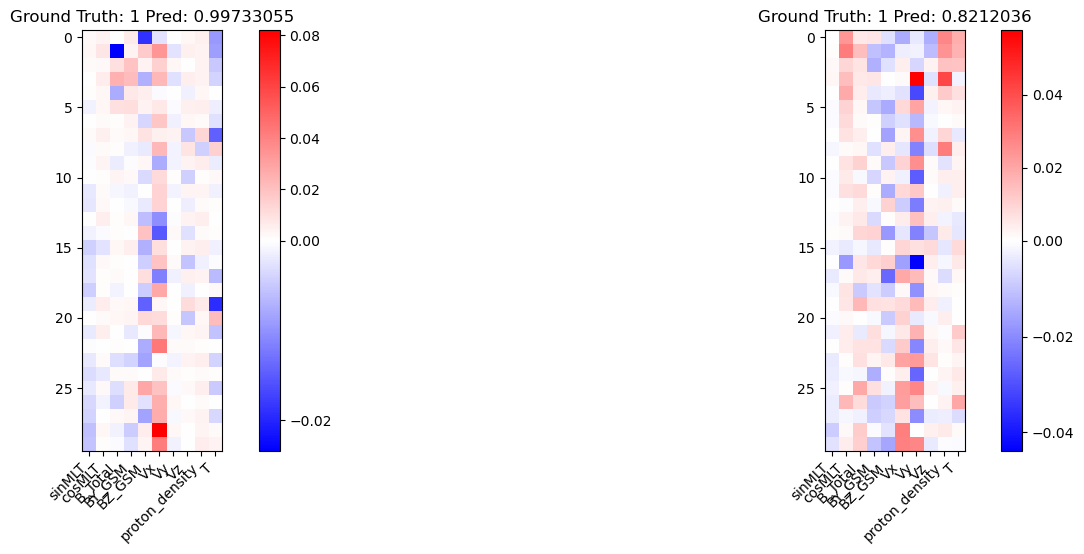

In [17]:
len_xtest = len(Xtest)
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(221)
step = random.randint(0,len_xtest)
plt.title('Ground Truth: '+str(test_dict['storm_4']['real_df']['crossing'][step])+' Pred: '+str(results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')

ax = plt.subplot(222)
step = random.randint(0,len_xtest)
plt.title('Ground Truth: '+str(test_dict['storm_4']['real_df']['crossing'][step])+' Pred: '+str(results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [22]:
print(shap_values[1].shape)
print(Xtest.shape)

(5072, 30, 10, 1)
(5072, 30, 10, 1)


In [51]:
def creating_plotting_df(shap_array, Xtest, scaler, param, param_loc):

	plotting_df = pd.DataFrame()

	shap_array = shap_array[:,:,:,0]
	Xtest = Xtest[:,:,:,0]

	nums = [30-i for i in range(30)]
	i = 0
	for arr, test in zip(shap_array, Xtest):
		test = scaler.inverse_transform(test)
		df = pd.DataFrame({'shap_values':arr[:, param_loc],
							param: test[:, param_loc],
							'time_hist':nums})
		if i == 500:
			print(df)
		plotting_df = pd.concat([plotting_df, df], axis=0).reset_index(drop=True)
		i+=1
	print(i)
	return plotting_df

In [52]:
plotting_df = creating_plotting_df(shap_values[1], Xtest, sw_scaler, 'Vx', features.index('Vx'))

    shap_values          Vx  time_hist
0           NaN         NaN         30
1           NaN         NaN         29
2           NaN         NaN         28
3           NaN         NaN         27
4           NaN         NaN         26
5           NaN         NaN         25
6           NaN         NaN         24
7           NaN         NaN         23
8           NaN         NaN         22
9           NaN         NaN         21
10          NaN         NaN         20
11          NaN         NaN         19
12          NaN         NaN         18
13          NaN         NaN         17
14          NaN         NaN         16
15          NaN         NaN         15
16          NaN         NaN         14
17          NaN         NaN         13
18          NaN  598.820007         12
19          NaN  598.820007         11
20          NaN  598.820007         10
21          NaN  598.820007          9
22          NaN  598.820007          8
23          NaN  598.820007          7
24          NaN  598.8200

In [34]:
plotting_df[500:502]

,shap_values,Vx,time_hist
20,NaN,NaN,10
21,NaN,NaN,9
